<a href="https://colab.research.google.com/github/JvitorS23/notebooks-PIBIC/blob/master/kdRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports e seed


In [0]:
import os.path
from scipy.io import arff
import pandas as pd
from random import randint
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
import time
import random
from scipy.signal import resample
seed =23
random.seed(seed)

# Download dos dados


In [0]:
!rm -rf /content/heartbeat_dataset

In [3]:
!mkdir heartbeat_dataset
!wget -P  /content/heartbeat_dataset https://www.dropbox.com/s/nxclm1me16kmik7/heartbeat_dataset.zip
!unzip -d /content/heartbeat_dataset /content/heartbeat_dataset/heartbeat_dataset.zip

--2020-02-20 00:36:40--  https://www.dropbox.com/s/nxclm1me16kmik7/heartbeat_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nxclm1me16kmik7/heartbeat_dataset.zip [following]
--2020-02-20 00:36:40--  https://www.dropbox.com/s/raw/nxclm1me16kmik7/heartbeat_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7855e784aac8ad52a8cd317986.dl.dropboxusercontent.com/cd/0/inline/AyYJaJpHu2uXryAgwIReo-thnNb0SEM9GTeuhge1oRRMYT7fL6YgEKEClc-dDu1CqdzWqaLThoyjzB6MjSBbT9bWVHDrYuJ43lYF-RgrWsWJdf-zTNQPA3gVM5AHydqhS2A/file# [following]
--2020-02-20 00:36:40--  https://uc7855e784aac8ad52a8cd317986.dl.dropboxusercontent.com/cd/0/inline/AyYJaJpHu2uXryAgwIReo-thnNb0SEM9GTeuhge1oRRMYT7fL6YgEKEClc-dDu1CqdzWqaLThoyjzB6MjSBb

# Tratamento dos Dados


In [0]:
df = pd.read_csv("/content/heartbeat_dataset/mitbih_train.csv", header=None)
df[187].value_counts()


0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [0]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)


In [0]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()


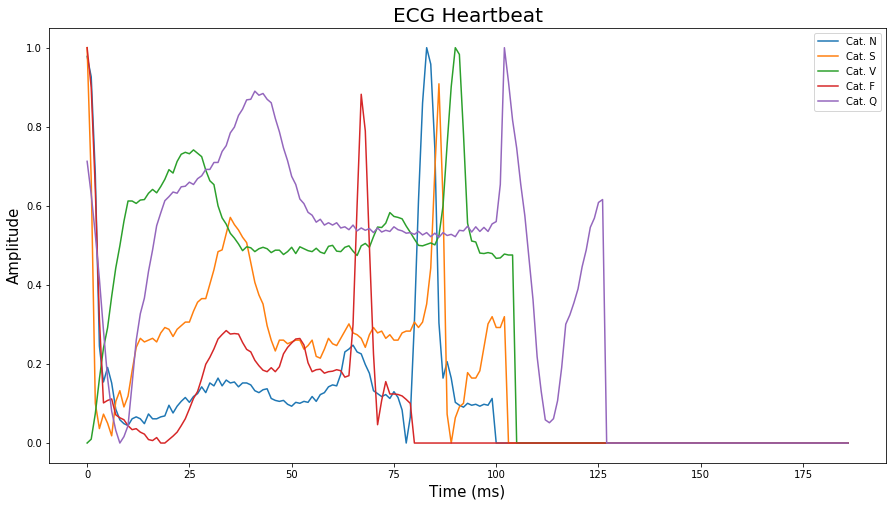

In [0]:
x = np.arange(0, 187)
plt.figure(figsize=(15,8))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("ECG Heartbeat", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [0]:
def ecg_data():
  #read the data
  df = pd.read_csv("/content/heartbeat_dataset/mitbih_train.csv", header=None)
  df2 = pd.read_csv("/content/heartbeat_dataset/mitbih_test.csv", header=None)
  df = pd.concat([df, df2], axis=0)

  # define data samples
  X = df.iloc[0:,0:187].values

  # standardize data
  min_max_scaler = preprocessing.MinMaxScaler()
  X_short = min_max_scaler.fit_transform(X)

  # define target
  y_short = df.iloc[0:,187].values.astype(int)

  # define model parameters
  samples = X_short.shape[0] # how many trials of eeg data
  n_features = X_short.shape[1] # how many channels of eeg in each sample
  time_steps = 1 # how many ms was each sample run for

  # use stratshufflesplit to get indices for test and training data
  sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=seed)
  sss.get_n_splits(X_short, y_short)

  # take the indices generated by stratified shuffle split and make the test and training datasets
  for train_index, test_index in sss.split(X_short, y_short):
    X_train, X_test = X_short[train_index], X_short[test_index]
    y_train, y_test = y_short[train_index], y_short[test_index]

  X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
  y_train = y_train.reshape(y_train.shape[0], time_steps)
  X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0], time_steps)    

  return X_train, y_train, X_test, y_test, time_steps, n_features

class ECG_dataset(Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx],self.labels[idx]

def prepararDados():
  #Download e preparação dos dados
  x_train, y_train, x_test, y_test, time_steps, n_features = ecg_data()
    
  train_data = torch.from_numpy(x_train).type(torch.Tensor)
  test_data = torch.from_numpy(x_test).type(torch.Tensor)
  train_labels = torch.from_numpy(y_train).type(torch.LongTensor).view(-1)
  test_labels = torch.from_numpy(y_test).type(torch.LongTensor).view(-1)

  #Cria o Dataset a partir dos dados
  train_set = ECG_dataset(train_data, train_labels)
  valid_set = ECG_dataset(train_data, train_labels)
  test_set = ECG_dataset(test_data, test_labels)

  valid_size = 0.25
  random_seed = 23

  num_train = len(train_set)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))

  # Embaralha os indices
  np.random.seed(random_seed)
  np.random.shuffle(indices)

  # faz o split do dataset
  train_idx, valid_idx = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  #Cria o batch loader
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, sampler=train_sampler, num_workers=0)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, sampler=valid_sampler, num_workers=0)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

  return train_loader, valid_loader, test_loader

In [0]:

class ECG_dataset(Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx],self.labels[idx]

def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor


def balancearDataset():

# essa função divide os dados por categoria e acrescenta amostrar nas categorias com menos de 20000 amostras
# essa adição de amostras é feita usando data augmentation, aplicando amplificação e encolhimento na série temporal 
  train = pd.read_csv("/content/heartbeat_dataset/mitbih_train.csv", header=None)  

  X = train.iloc[0:,0:187].values

  # standardize data
  min_max_scaler = preprocessing.MinMaxScaler()
  X = min_max_scaler.fit_transform(X)

  # define target
  y = train.iloc[0:,187].values.astype(int)

  #encontra os indices de cada classe
  C0_idx = np.argwhere(y == 0).flatten()
  C1_idx = np.argwhere(y == 1).flatten()
  C2_idx = np.argwhere(y == 2).flatten()
  C3_idx  = np.argwhere(y == 3).flatten()
  C4_idx  = np.argwhere(y == 4).flatten()

  #serapa as amostras por classe
  C0 = X[C0_idx[0:20000]]
  C1 = X[C1_idx]
  C2 = X[C2_idx]
  C3 = X[C3_idx]
  C4 = X[C4_idx]   

  # cria novas amostras pra cada categoria usando data augmentation   
  while len(C1)<20000:    
    idx = randint(0, len(C1)-1)
    aug = randint(0,1)
    if aug == 0:
      C1 = np.append(C1, [amplify(C1[idx])],axis=0)
    else:
      C1 = np.append(C1, [stretch(C1[idx])],axis=0)

  while len(C2)<20000:
    idx = randint(0, len(C2)-1)
    aug = randint(0,1)
    if aug == 0:
      C2 = np.append(C2, [amplify(C2[idx])],axis=0)
    else:
      C2 = np.append(C2, [stretch(C2[idx])],axis=0)

  while len(C3)<20000:
    idx = randint(0, len(C3)-1)
    aug = randint(0,1)
    if aug == 0:
      C3 = np.append(C3, [amplify(C3[idx])],axis=0)
    else:
       C3 = np.append(C3, [stretch(C3[idx])],axis=0)  

  while len(C4)<20000:
    idx = randint(0, len(C4)-1)
    aug = randint(0,1)
    if aug == 0:
      C4 = np.append(C4, [amplify(C4[idx])],axis=0)
    else:
      C4 = np.append(C4, [stretch(C4[idx])],axis=0)     
   
  # concatena as categorias
  data = np.append(C0,C1, axis=0)
  data = np.append(data, C2, axis=0)
  data = np.append(data, C3, axis=0)
  data = np.append(data, C4, axis=0) 

  #cria as labels
  labels = np.append(np.zeros(len(C0)), np.ones(len(C1)),axis=0)
  labels = np.append(labels, np.ones(len(C2))*2, axis=0)
  labels = np.append(labels, np.ones(len(C3))*3, axis=0)
  labels = np.append(labels, np.ones(len(C4))*4, axis=0)


  sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=seed)
  sss.get_n_splits(data, labels)

  for train_index, val_index in sss.split(data, labels):
    X_train, X_val = data[train_index], data[val_index]
    y_train, y_val = labels[train_index], labels[val_index]  
  
  #test dataset
  test  = pd.read_csv("/content/heartbeat_dataset/mitbih_test.csv", header=None)  
  
  # define data samples
  X_test = test.iloc[0:,0:187].values
  
  time_steps = 1

  # define target
  y_test = test.iloc[0:,187].values.astype(int)
  X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])
  y_test = y_test.reshape(y_test.shape[0], time_steps)

  X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
  y_train = y_train.reshape(y_train.shape[0], time_steps)
  X_val = X_val.reshape(X_val.shape[0], time_steps, X_val.shape[1])
  y_val = y_val.reshape(y_val.shape[0], time_steps)   

  print(len(X_train), len(X_val))

  return X_train, y_train, X_val, y_val, X_test, y_test  

def getLoaders():
  X_train, y_train, X_val, y_val, X_test, y_test = balancearDataset()

  #transformar em tensores
  train_data   = torch.from_numpy(X_train).type(torch.Tensor)
  valid_data   = torch.from_numpy(X_val).type(torch.Tensor)
  test_data    = torch.from_numpy(X_test).type(torch.Tensor)

  train_labels = torch.from_numpy(y_train).type(torch.LongTensor).view(-1)
  valid_labels = torch.from_numpy(y_val).type(torch.LongTensor).view(-1)
  test_labels  = torch.from_numpy(y_test).type(torch.LongTensor).view(-1)

  #Cria o Dataset a partir dos dados
  train_set = ECG_dataset(train_data, train_labels)
  valid_set = ECG_dataset(valid_data, valid_labels)
  test_set  = ECG_dataset(test_data, test_labels)

  #Cria o batch loader
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False, num_workers=0)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=0)
  test_loader  = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

  return train_loader, valid_loader, test_loader 

# Modelo LSTM


In [0]:
class ModeloLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, batch):
    super().__init__()
    self.bs = batch
    self.numLayers = 1
    self.hidden_size = hidden_size
    #LSTM layer, batch_first para usar batchs
    self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=self.numLayers, batch_first=True)#num_layers é a quantidade de celulas LSTM agrupadas
    self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=self.numLayers, batch_first=True)#num_layers é a quantidade de celulas LSTM agrupadas
    self.lstm3 = nn.LSTM(hidden_size, hidden_size, num_layers=self.numLayers, batch_first=True)#num_layers é a quantidade de celulas LSTM agrupadas
    self.linear = nn.Linear(hidden_size, 5)
    self.drop = nn.Dropout(p=0.5)
  
  def forward(self, input):
    h0 = c0 = torch.zeros(self.numLayers,input.shape[0],self.hidden_size)
    if torch.cuda.is_available():
        h0 = h0.cuda()
        c0 = c0.cuda()    
    lstm1_out, (h0,c0) = self.lstm1(input, (h0,c0))    
    lstm2_out, (h0,c0) = self.lstm2(lstm1_out, (h0,c0))
    drop1 = self.drop(lstm2_out)
    lstm3_out, (h0,c0) = self.lstm3(drop1, (h0,c0))    
    drop2 = self.drop(lstm3_out)
    predictions = self.linear(drop2.view(len(input), -1))
    return predictions

# Plotar


In [0]:
def plotar(train_loss, train_acc, val_loss, val_acc):
  plt.title('Accuracy over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(train_acc, label='train')
  plt.plot(val_acc, label='val')
  plt.grid(True, which='both', axis='both')  
  plt.tight_layout()
  plt.legend()
  plt.show()
  plt.title('Loss over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(train_loss, label='train')
  plt.plot(val_loss, label='val')
  plt.grid(True, which='both', axis='both')
  plt.tight_layout()
  plt.legend()
  plt.show()

# Salvar e Carregar


In [0]:
def carregar_modeloLSTM(model_save_name):
  model = ModeloLSTM(187, 30, 32)
  model.load_state_dict(torch.load(model_save_name))
  return model

def carregar_modeloBLSTM(model_save_name):
  model = ModeloBLSTM(14, 28, 32)
  model.load_state_dict(torch.load(model_save_name))
  return model

def carregar_modeloRNN(model_save_name):
  model = ModeloRNN(187, 20, 32)
  model.load_state_dict(torch.load(model_save_name))
  return model


def salvar_modelo(model, model_save_name):
  torch.save(model.state_dict(), model_save_name)

# Early stopping

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
              print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'bestLoss.model')
        self.val_loss_min = val_loss

# Função de treinamento

In [0]:
def treinamento(train_loader, valid_loader, model, num_epochs, verbose):
  train_losses , train_accuracy = [],[]
  val_losses , val_accuracy = [],[]
  totalTime = 0
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # sets optimizer
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=20, verbose=verbose, min_lr=0.00005)
  best_loss, best_acc = fit(verbose, optimizer, scheduler,model,valid_loader, phase='validation')
  
  if verbose:
    print("best_acc: " + str(best_acc))

  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=30, verbose=verbose)

  for epoch in range(1,num_epochs+1):
    if verbose:   
      print('epoch {}/{}'.format(epoch, num_epochs))
      print('=' * 10)
    epochStart = time.time()
    train_epoch_loss, train_epoch_accuracy = fit(verbose, optimizer, scheduler, model, train_loader, phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(verbose, optimizer, scheduler, model, valid_loader, phase='validation')
    epochEnd = time.time() 

    if verbose:   
      print('Duração:', (epochEnd - epochStart))

    if val_epoch_accuracy >= best_acc:
      best_acc = val_epoch_accuracy
      best_loss = val_epoch_loss
      salvar_modelo(model, 'bestAccuracy.model')
    
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
   
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
      print("Early stopping in epoch", epoch)
      break
  
  return train_losses, train_accuracy, val_losses, val_accuracy 

def fit(verbose, optimizer, scheduler, model, data_loader, phase='training'):
  if phase == 'training':
    model.train()
  if phase == 'validation':
    model.train
  running_loss = 0.0
  running_correct = 0

  for batch in data_loader:
    data , target = batch     
    
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    
    if phase == 'training':
      optimizer.zero_grad()
    
    output = model(data)
    loss = F.cross_entropy(output,target)

    running_loss += loss
    preds = output.data.max(dim=1,keepdim=True)[1]       
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()

    if phase == 'training':
      loss.backward()
      optimizer.step()    
  loss = running_loss/len(data_loader.sampler)
  accuracy = 100. * running_correct/len(data_loader.sampler)

  if verbose:
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.sampler)}{accuracy:{6}.{4}}%')
  return loss,accuracy

# Info modelo


In [0]:
def infoModelo(model):
  print(model)  
  pytorch_total_params = sum(p.numel() for p in model.parameters())
  pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print('Total params: ', pytorch_total_params)
  print('Trainable params: ', pytorch_trainable_params)


# Teste do modelo

In [0]:
def testeDoModelo(model, data_loader):
  if (torch.cuda.is_available()):
    model = model.cuda()
  model.eval()
  running_loss = 0.0
  running_correct = 0    
  tot_predictions = []
  labels = []
  for batch in data_loader:
    data , target = batch        
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    output = model(data)
    loss = F.cross_entropy(output,target)
    running_loss += loss.item()    
    preds = output.data.max(dim=1,keepdim=True)[1]
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()
    tot_predictions.extend(preds.data.cpu().numpy())
    labels.extend(target.data.cpu().numpy())
        
  loss = running_loss/len(data_loader.sampler)
  accuracy = 100. * running_correct/len(data_loader.sampler)  
  print(f'Test loss is {loss:{5}.{2}} and Test accuracy is {running_correct}/{len(data_loader.sampler)}{accuracy:{6}.{4}}%\n')
  return tot_predictions, labels


def logitsDoModelo(model, data_loader):
  if (torch.cuda.is_available()):
    model = model.cuda()
  model.eval()
  running_loss = 0.0
  running_correct = 0  
  corrects = 0  
  logits = []
  for batch in data_loader:
    data , target = batch        
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    output = model(data)
    loss = F.cross_entropy(output,target)
    running_loss += loss.item()    
    preds = output.data.max(dim=1,keepdim=True)[1]
    logits.extend(output.data.cpu().numpy())
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()    
  loss = running_loss/len(data_loader.sampler)
  accuracy = 100. * running_correct/len(data_loader.sampler)  
  print(f'Test loss is {loss:{5}.{2}} and Test accuracy is {running_correct}/{len(data_loader.sampler)}{accuracy:{6}.{4}}%\n')
  return logits

# Treinamento LSTM dataset desbalanceado


In [320]:
#Download e preparação dos dados
train_loader, valid_loader, test_loader = prepararDados()

#verificação CUDA
print('CUDA', torch.cuda.is_available())

#Cria o modelo 
model = ModeloLSTM(187, 30, 32)

if(torch.cuda.is_available):
  model = model.cuda()

infoModelo(model)

CUDA True
ModeloLSTM(
  (lstm1): LSTM(187, 30, batch_first=True)
  (lstm2): LSTM(30, 30, batch_first=True)
  (lstm3): LSTM(30, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Total params:  41315
Trainable params:  41315


In [224]:
train_losses, train_accuracy, val_losses, val_accuracy  = treinamento(train_loader, valid_loader, model, 20, True)

validation loss is 0.056 and validation accuracy is 1519/21889  6.94%
best_acc: 6.939558682443236
epoch 1/20
training loss is 0.014 and training accuracy is 57744/65667 87.93%
validation loss is 0.0086 and validation accuracy is 20326/21889 92.86%
Duração: 11.189760684967041
Validation loss decreased (inf --> 0.008567).  Saving model ...
epoch 2/20
training loss is 0.0077 and training accuracy is 61598/65667  93.8%
validation loss is 0.0064 and validation accuracy is 20696/21889 94.55%
Duração: 11.250930070877075
Validation loss decreased (0.008567 --> 0.006364).  Saving model ...
epoch 3/20
training loss is 0.0061 and training accuracy is 62513/65667  95.2%
validation loss is 0.0055 and validation accuracy is 20891/21889 95.44%
Duração: 10.789093255996704
Validation loss decreased (0.006364 --> 0.005512).  Saving model ...
epoch 4/20
training loss is 0.0053 and training accuracy is 62843/65667  95.7%
validation loss is 0.0051 and validation accuracy is 20983/21889 95.86%
Duração: 10.9

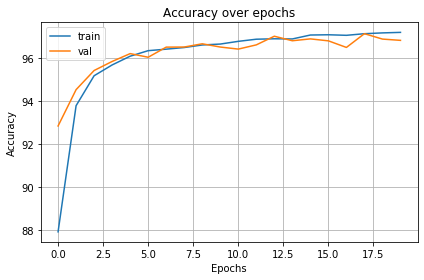

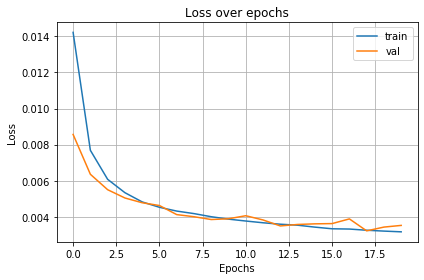

In [225]:
plotar(train_losses, train_accuracy, val_losses, val_accuracy)

Métricas e matriz de confusão usando dataset desbalanceado

In [226]:
from sklearn.metrics import classification_report
print('========= Modelo com melhor Loss no conjunto de validação ============\n')
model = carregar_modeloLSTM('bestLoss.model')
if (torch.cuda.is_available()):
  model = model.cuda()
y_pred, y_test = testeDoModelo(model, test_loader)
target_names = ['N', 'S', 'V', 'F', 'Q']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
print('\n\n')

========= Modelo com melhor Loss no conjunto de validação ============

Test loss is 0.0033 and Test accuracy is 21252/21890 97.09%

              precision    recall  f1-score   support

           N      0.977     0.993     0.985     18118
           S      0.887     0.622     0.732       556
           V      0.923     0.909     0.916      1447
           F      0.855     0.441     0.582       161
           Q      0.975     0.955     0.964      1608

    accuracy                          0.971     21890
   macro avg      0.923     0.784     0.836     21890
weighted avg      0.970     0.971     0.969     21890






========= Confusion Matrix  melhor Loss no conjunto de validação ============

Test loss is 0.0033 and Test accuracy is 21252/21890 97.09%



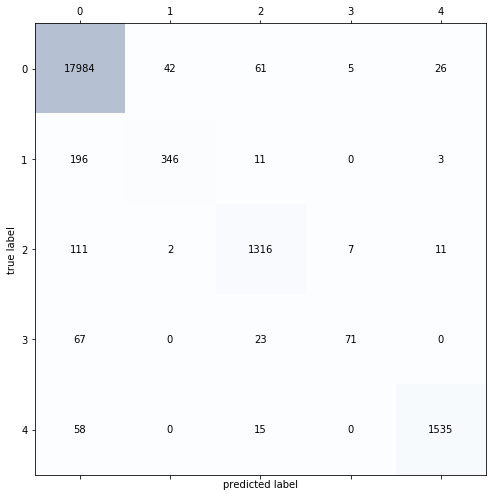

In [227]:
from sklearn.metrics import confusion_matrix
print('========= Confusion Matrix  melhor Loss no conjunto de validação ============\n')
model = carregar_modeloLSTM('bestLoss.model')
if (torch.cuda.is_available()):
  model = model.cuda()

y_pred, y_test = testeDoModelo(model, test_loader)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [228]:
y_pred, y_test = testeDoModelo(model, train_loader)

Test loss is 0.0026 and Test accuracy is 64142/65667 97.68%



In [229]:
y_pred, y_test = testeDoModelo(model, valid_loader)

Test loss is 0.0032 and Test accuracy is 21266/21889 97.15%



In [230]:
y_pred, y_test = testeDoModelo(model, test_loader)

Test loss is 0.0033 and Test accuracy is 21252/21890 97.09%



In [327]:
#verificação CUDA
print('CUDA', torch.cuda.is_available())

#Cria o modelo 
model = ModeloLSTM(187, 30, 32)

if(torch.cuda.is_available):
  model = model.cuda()

infoModelo(model)


CUDA True
ModeloLSTM(
  (lstm1): LSTM(187, 30, batch_first=True)
  (lstm2): LSTM(30, 30, batch_first=True)
  (lstm3): LSTM(30, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Total params:  41315
Trainable params:  41315


In [328]:
train_loader, valid_loader, test_loader = getLoaders()


80000 20000


In [329]:

train_losses, train_accuracy, val_losses, val_accuracy  = treinamento(train_loader, valid_loader, model, 2, True)


validation loss is  0.05 and validation accuracy is 3423/20000 17.11%
best_acc: 17.115
epoch 1/2
training loss is 0.023 and training accuracy is 58381/80000 72.98%
validation loss is 0.017 and validation accuracy is 16244/20000 81.22%
Duração: 12.511606931686401
Validation loss decreased (inf --> 0.017049).  Saving model ...
epoch 2/2
training loss is 0.015 and training accuracy is 66801/80000  83.5%
validation loss is 0.014 and validation accuracy is 17012/20000 85.06%
Duração: 13.336897850036621
Validation loss decreased (0.017049 --> 0.013840).  Saving model ...


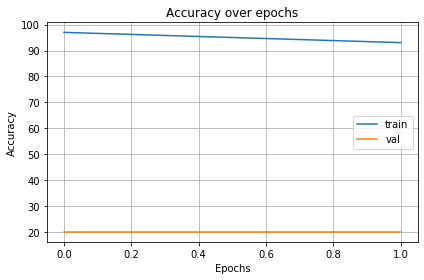

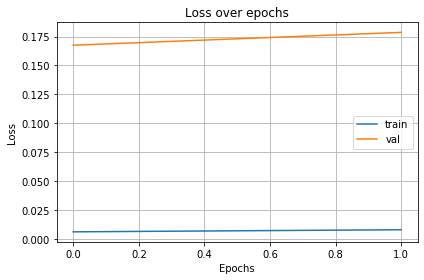

In [289]:
plotar(train_losses, train_accuracy, val_losses, val_accuracy)

In [304]:
from sklearn.metrics import classification_report
print('========= Modelo com melhor Loss no conjunto de validação ============\n')
model = carregar_modeloLSTM('bestLoss.model')
if (torch.cuda.is_available()):
  model = model.cuda()
y_pred, y_test = testeDoModelo(model, train_loader)
target_names = ['N', 'S', 'V', 'F', 'Q']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
print('\n\n')

========= Modelo com melhor Loss no conjunto de validação ============

Test loss is  0.14 and Test accuracy is 6231/34083 18.28%

              precision    recall  f1-score   support

           N      0.000     0.000     0.000     19800
           S      0.000     0.000     0.000      2023
           V      0.000     0.000     0.000      5588
           F      0.000     0.000     0.000       441
           Q      0.183     1.000     0.309      6231

    accuracy                          0.183     34083
   macro avg      0.037     0.200     0.062     34083
weighted avg      0.033     0.183     0.057     34083






/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


========= Confusion Matrix  melhor Loss no conjunto de validação ============

Test loss is  0.15 and Test accuracy is 6231/34083 18.28%



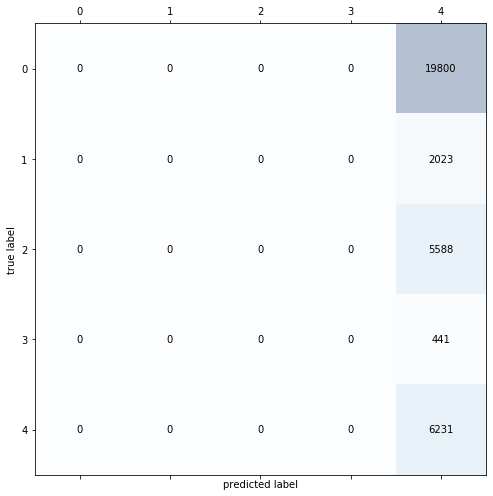

In [301]:
from sklearn.metrics import confusion_matrix
print('========= Confusion Matrix  melhor Loss no conjunto de validação ============\n')
model = carregar_modeloLSTM('bestLoss.model')
if (torch.cuda.is_available()):
  model = model.cuda()

y_pred, y_test = testeDoModelo(model, train_loader)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=500)
plt.show()

# Teste do modelo LSTM


In [0]:
modelBL = carregar_modeloLSTM('bestLoss.model')
train_logits = logitsDoModelo(modelBL, train_loader)
train_logits = torch.tensor(train_logits)
train_logit = train_logits.cuda()

Test loss is 0.002 and Test accuracy is 64407/65667 98.08%



In [0]:
valid_logits = logitsDoModelo(modelBL, valid_loader)
valid_logits = torch.tensor(valid_logits)
valid_logits = valid_logits.cuda()


Test loss is 0.0028 and Test accuracy is 21329/21889 97.44%



In [0]:
test_logits = logitsDoModelo(modelBL, test_loader)
test_logits = torch.tensor(test_logits)
test_logits = test_logits.cuda()


Test loss is 0.0029 and Test accuracy is 21316/21890 97.38%



# Modelo RNN


In [0]:
class ModeloRNN(nn.Module):
  def __init__(self, input_size, hidden_size, batch):
    super().__init__()
    self.bs = batch
    self.numLayers = 1
    self.hidden_size = hidden_size
    self.rnn1 = nn.RNN(input_size, hidden_size, num_layers=self.numLayers, batch_first=True)
    self.rnn2 = nn.RNN(hidden_size, hidden_size, num_layers=self.numLayers, batch_first=True)
    self.rnn3 = nn.RNN(hidden_size, hidden_size, num_layers=self.numLayers, batch_first=True)
    self.linear = nn.Linear(hidden_size, 1)
    self.sm = nn.Sigmoid()
    self.drop = nn.Dropout(p=0.5)
  
  def forward(self, input):
    h0 = torch.zeros(self.numLayers,input.shape[0],self.hidden_size)
    if torch.cuda.is_available():
        h0 = h0.cuda()           
    rnn1_out, h0 = self.rnn1(input, h0)    
    rnn2_out, h0 = self.rnn2(rnn1_out, h0)
    drop1 = self.drop(rnn2_out)
    rnn3_out, h0 = self.rnn3(drop1, h0)    
    drop2 = self.drop(rnn3_out)
    predictions = self.linear(drop2.view(len(input), -1))
    return self.sm(predictions)

# Treinamento convencional modelo RNN dataset desbalanceado

In [0]:
#Download e preparação dos dados
train_loader, valid_loader, test_loader = prepararDados()

#verificação CUDA
print('CUDA', torch.cuda.is_available())

#Cria o modelo 
model2 = ModeloRNN(187, 20, 32)

if(torch.cuda.is_available):
  model2 = model2.cuda()

infoModelo(model2)

CUDA True


RuntimeError: ignored

In [0]:
train_losses, train_accuracy, val_losses, val_accuracy  = treinamento(train_loader, valid_loader, model2, 50, True)

RuntimeError: ignored

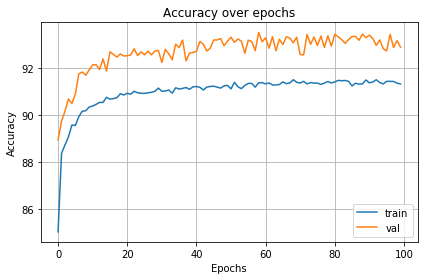

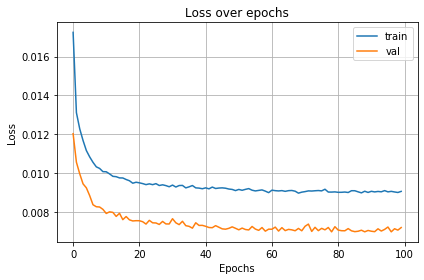

In [0]:
plotar(train_losses, train_accuracy, val_losses, val_accuracy)

# Teste RNN

In [0]:
modelBL = carregar_modeloRNN('bestLoss.model')
train_out = testeDoModelo(modelBL, train_loader)


Test loss is 0.0068 and Test accuracy is 61391/65667 93.49%



In [0]:
valid_out = testeDoModelo(modelBL, valid_loader)



Test loss is 0.007 and Test accuracy is 20443/21889 93.39%



In [0]:
test_out = testeDoModelo(modelBL, test_loader)



Test loss is 0.0073 and Test accuracy is 20404/21890 93.21%



# Função Treinamento KD


In [0]:
def treinamentoSoft(train_logits, valid_logits, train_loader, valid_loader, model, num_epochs, verbose):
  train_losses , train_accuracy = [],[]
  val_losses , val_accuracy = [],[]
  totalTime = 0
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # sets optimizer
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=50, verbose=verbose, min_lr=0.00005)
  best_loss, best_acc = fitSoft(valid_logits, verbose, optimizer, scheduler,model,valid_loader, phase='validation')
  
  if verbose:
    print("best_acc: " + str(best_acc))

  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=100, verbose=verbose)

  for epoch in range(1,num_epochs+1):
    if verbose:   
      print('epoch {}/{}'.format(epoch, num_epochs))
      print('=' * 10)
    epochStart = time.time()
    train_epoch_loss, train_epoch_accuracy = fitSoft(train_logits, verbose, optimizer, scheduler, model, train_loader, phase='training')
    val_epoch_loss , val_epoch_accuracy = fitSoft(valid_logits, verbose, optimizer, scheduler, model, valid_loader, phase='validation')
    epochEnd = time.time() 

    if verbose:   
      print('Duração:', (epochEnd - epochStart))

    if val_epoch_accuracy >= best_acc:
      best_acc = val_epoch_accuracy
      best_loss = val_epoch_loss
      salvar_modelo(model, 'bestAccuracy.model')
    
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
   
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
      print("Early stopping in epoch", epoch)
      break
  
  return train_losses, train_accuracy, val_losses, val_accuracy 

def fitSoft(teacher_target, verbose, optimizer, scheduler, model, data_loader, phase='training'):
  if phase == 'training':
    model.train()
  if phase == 'validation':
    model.eval()
  running_loss = 0.0
  running_correct = 0
  ini = 0
  fim = 0
  for batch in data_loader:
    data , target = batch        
    fim = fim + len(target)
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    soft_target = teacher_target[ini:fim]
    loss = loss_fn_kd(output, target, soft_target, 4)
    running_loss += loss.item()
    output = output.data.cpu().numpy()   
    preds = np.argmax(output, axis=1)     
    running_correct += getCorrects(preds, target)
    if phase == 'training':
      loss.backward()
      optimizer.step()   
    ini = ini + len(target) 
  loss = running_loss/len(data_loader.sampler)
  accuracy = 100. * running_correct/len(data_loader.sampler)
  if phase == 'validation':
    scheduler.step(accuracy)
  if verbose:
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.sampler)}{accuracy:{6}.{4}}%')
  return loss,accuracy


def loss_fn_kd(outputs, labels, teacher_outputs, temperature): 
  """ 
  Compute the knowledge-distillation (KD) loss given outputs, labels. 
  "Hyperparameters": temperature and alpha 

  NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher 
  and student expects the input tensor to be log probabilities! See Issue #2 
  """ 
  alpha = 0.9
  T = temperature 
  KD_loss = nn.KLDivLoss()(F.softmax(outputs/T, dim=1), 
                          F.softmax(teacher_outputs/T, dim=1))*T*T*alpha + F.cross_entropy(outputs, labels) * (1. - alpha) 

  return KD_loss 

def getCorrects(preds, targets):  
  corretos = 0
  for i in range(0, len(targets)):
    if preds[i].item() == targets[i].item():
      corretos = corretos +1

  return corretos


# Treinamento modelo RNN com KD

In [0]:
#Download e preparação dos dados
train_loader, valid_loader, test_loader = prepararDados()

#verificação CUDA
print('CUDA', torch.cuda.is_available())

#Cria o modelo 
model = ModeloRNN(187, 30, 32)

if(torch.cuda.is_available):
  model = model.cuda()

infoModelo(model)

CUDA True


RuntimeError: ignored

In [0]:
train_losses, train_accuracy, val_losses, val_accuracy = treinamentoSoft(train_logit, valid_logits, train_loader, valid_loader, model, 100, True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


validation loss is -0.012 and validation accuracy is 1216/21889 5.555%
best_acc: 5.555301749737311
epoch 1/100
training loss is -0.039 and training accuracy is 54787/65667 83.43%
validation loss is -0.043 and validation accuracy is 19202/21889 87.72%
Duração: 8.984133005142212
Validation loss decreased (inf --> -0.043240).  Saving model ...
epoch 2/100
training loss is -0.043 and training accuracy is 57155/65667 87.04%
validation loss is -0.046 and validation accuracy is 19562/21889 89.37%
Duração: 9.642857789993286
Validation loss decreased (-0.043240 --> -0.045639).  Saving model ...
epoch 3/100
training loss is -0.044 and training accuracy is 57730/65667 87.91%
validation loss is -0.047 and validation accuracy is 19713/21889 90.06%
Duração: 9.550994396209717
Validation loss decreased (-0.045639 --> -0.046876).  Saving model ...
epoch 4/100
training loss is -0.046 and training accuracy is 58213/65667 88.65%
validation loss is -0.048 and validation accuracy is 19883/21889 90.84%
Duraç

# Teste RNN KD


In [0]:
modelBL = carregar_modeloRNN('bestLoss.model')
train_out = testeDoModelo(modelBL, train_loader)


Test loss is 0.0088 and Test accuracy is 61621/65667 93.84%



In [0]:
valid_out = testeDoModelo(modelBL, valid_loader)



Test loss is 0.0093 and Test accuracy is 20531/21889  93.8%



In [0]:
test_out = testeDoModelo(modelBL, test_loader)


Test loss is 0.0098 and Test accuracy is 20490/21890  93.6%

